# Data exercise: Explore sound recordings

In this data exercise, we will apply the concepts that we have learned so far to analyze different types of sounds.

In the [`BOAT_exercises/example_wav` folder](https://drive.google.com/drive/u/0/folders/1Qk9LF3tdJHySdgSfyWVjbjPOfk2ODoMO), you will find a collection of many wav files. Download the files assigned to your group to begin exploring working with these real-world data!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.io.wavfile as wavfile
import scipy.fft as fft

from pathlib import Path
import IPython.display as ipd
import ipywidgets as widgets

In [2]:
from IPython.display import display, HTML

Below in this notebook, we walk through the steps you need to read and analyze sound from the data files.

## Read a `.wav` file

Sound recording can come in many different file formats, but `.wav` files are by far the most common. You can use the example code below to read in the samples from an example `.wav` file.

In [3]:
wav_file_path = Path("../resources/example_sonar.wav")  # Swap out the file path

# Check if the provided file path does have this file -- if not, this will raise an error
assert(wav_file_path.exists())

### How does the recording sound like?

Let's first play it:

In [4]:
ipd.Audio(wav_file_path)

Notice there is a fainter da-da-da sound in the background in addition to the main sound (which is a sonar transmission and the following reverberation from the environment).

### How does the recording look like as a time series?

Let's load the recording samples and check some basic properties of the recording.

We will use the [`scipy.io.wavefile.read`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html) function to read the wav file.

In [5]:
# Load the audio file as an array of samples
# The function also reads in the sampling rate
sample_rate, audio_data = wavfile.read(wav_file_path)
audio_duration = audio_data.shape[0]/sample_rate  # compute the data duration in seconds

print(f"Reading in audio that is {audio_duration:.2f} sec long, "
      f"with a sampling rate of {sample_rate} Hz")

Reading in audio that is 11.97 sec long, with a sampling rate of 48000 Hz


In [6]:
# To plot the time correctly, we need to make a time vector
time_vec = np.arange(audio_data.shape[0]) / sample_rate

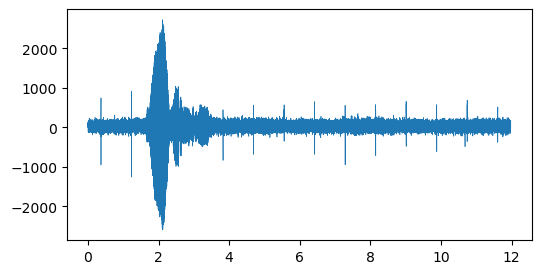

In [7]:
plt.figure(figsize=(6, 3))
plt.plot(time_vec, audio_data, lw=0.5)
plt.show()

Here, the example file only has 1 channel in it, so the plot simply shows 1 line. If there are multiple channels, you will see multiple, potentially lines being plotted. You can use `audio_data.shape` to change the "shape" of the data array:

In [8]:
audio_data.shape

(574786,)

Since there is only one channel in this wav file , you will only see one number. If the file contains 2 channels instead, you will see something like `(574786, 2)` as output.

### Exercise 1: How do the sound and the time series relate to each other?
Do the signal you see above make sense? Do the time series show the type of oscillations you expect? Try to make association between the sound you hear and features in the time series. What do you notice at the time of the sonar transmission, and the fainter background da-da-da sound?

### Exercise 2: Do the waveform values make sense?
This can be a difficult question to answer. The first thing to consider is that hydrophones record voltage signals. Does it make sense that the hydrophone was recording -2000 to +2000 V of signals? If not, what happened?

It turns out that [`scipy.io.wavfile.read`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html) does not automatically convert the quantized samples to the voltage swings for you. This particular file was quantized at 16-bit. We can see that by checking the file property in the file browser, like below ("Bits per sample"):

<img src="../images/exercises/01_bit_info.png" width="400px">

This corresponds to the data type read in by scipy:

In [9]:
audio_data.dtype

dtype('int16')

:::{tip}
Check out the [](primer-quantization) primer to review the concept of quantization!
:::

To scale it back the wav sample values, we can do:

In [10]:
audio_data_scale_temp = audio_data / 2**15

The colleague who collected the data also told us that there was some additional engineering signal conditioning considerations that made it such that to get the actual voltage, one has to scale the wav sample values by 3.27. So, to get to the actual voltage received by the hydrophone, we have to do:

In [11]:
audio_data_scale_full = audio_data / 2**15 * 3.27

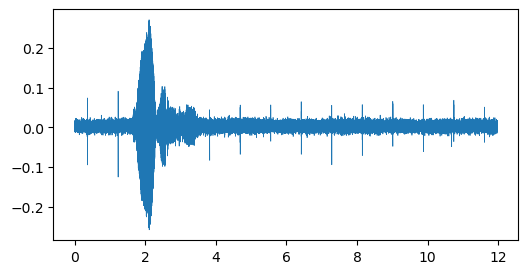

In [12]:
# Plot the time series as actual received voltage at the hydrophone
plt.figure(figsize=(6, 3))
plt.plot(time_vec, audio_data_scale_full, lw=0.5)
plt.show()

The above is why one should **always read the documentation** when you try to use a new function. For example, the documentation of the [scipy.io.wavfile.read](https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html) function did tell us about how samples of different bit depths are read:

<img src="../images/exercises/01_scipy_doc_bit_depth.png" width="600px">

## Spectrogram

Plotting the spectrogram is often one of the first steps to explore a new recording. Below let's use a widget to see what's in this file.

In [13]:
def plot_audio_segment(nfft, xlim, ylim):
    start_time = xlim[0]
    end_time = xlim[1]
    start_idx = int(xlim[0] * sample_rate)
    end_idx = int(xlim[1] * sample_rate)
    segment_time = time_vec[start_idx:end_idx]
    segment_audio = audio_data[start_idx:end_idx]

    
    fig, ax = plt.subplots(2, 1, figsize=(8, 6))

    # Time series
    cur_ax = ax[0]
    cur_ax.plot(segment_time, segment_audio, lw=0.5)
    cur_ax.set_xlim(start_time, end_time)
    cur_ax.set_title(f"Time series", fontsize=16)
    cur_ax.set_ylabel("Voltage (V)")
    
    time_series_xticks = ax[0].get_xticks()[ax[0].get_xticks()<=(end_time+1e-12)]

    # Spectrogram
    cur_ax = ax[1]
    Pxx, freqs, bins, im = cur_ax.specgram(
        segment_audio, Fs=sample_rate, NFFT=nfft,
        cmap='jet', vmin=-60, vmax=30)
    cur_ax.set_title(f"Spectrogram", fontsize=16)
    cur_ax.set_xticks(time_series_xticks - start_time, time_series_xticks.round(2))
    cur_ax.set_xlim(0, xlim[1]-xlim[0])
    cur_ax.set_ylim(ylim[0], ylim[1])
    cur_ax.set_ylabel("Frequency (Hz)")
    cur_ax.set_xlabel("Time (s)", fontsize=14)

    fig.tight_layout()

    plt.show()

In [14]:
nfft_slider = widgets.SelectionSlider(
    options=[256, 512, 1024, 2048],
    value=512,
    description="NFFT",
    continuous_update=False,
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

xlim_slider = widgets.FloatRangeSlider(
    value=[0, audio_duration],
    min=0,
    max=audio_duration,
    step=0.01,
    description='Display time limit (sec)',
    continuous_update=False,
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px')
)

ylim_slider = widgets.IntRangeSlider(
    value=[0, 24000],
    min=0,
    max=24000,
    step=100,
    description='Display frequency limit (Hz)',
    continuous_update=False,
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px')
)

widgets.interact(plot_audio_segment, nfft=nfft_slider, xlim=xlim_slider, ylim=ylim_slider)

interactive(children=(SelectionSlider(continuous_update=False, description='NFFT', index=1, layout=Layout(widt…

<function __main__.plot_audio_segment(nfft, xlim, ylim)>

### Exercise 3: How do the spectrogram change with the parameters?

In the initial view, you are seeing spectrogram from the entire signal. Try changing the various parameters to explore different part of the time series, and answer the following questions:
- What is the NFFT value that gives you the best time resolution and frequency resolution? Can they both have very high resolution?
- Can you estimate what the start and end frequency of the sonar transmission was approximately?

## Quantify sound level

Knowing how the recording "looks" like, let's now try to quantify the sound samples.

The colleague who collected the data also told us that the sound was recorded with the following parameters:
- Receiver sensitivity: -160 dB re 1V/µPa
- Gain: 12 dB

### Exercise 4
By referencing the tutorials on [hydrophone](acoustics-receiver_hydrophone_sensitivity), [sound metrics](acoustics-receiver_metrics), and [decibel](primer-decibel):
- Could you estimate what the RMS SPL of this recording is?
- As you have heard/seen, the recording contains different signals in different sections. Can you estimate their RMS SPL separately?
- Where are your RMS SPL estimates located on the Wenz curves?

**Hint 1**: To slice out different sections, the code snippet below may be helpful:

```python
start_time = 1.0  # section start time [second]
end_time = 3.5  # section end time [second]
start_index = np.floor(start_time * sample_rate).astype(int)  # index at start time [sample number]
end_index = np.ceil(end_time * sample_rate).astype(int)  # index at end time [sample number]
audio_section = audio_data[start_index:end_index]
```

**Hint 2**: To compute RMS SPL, recall that RMS for discrete signal is:

  $$\sqrt{\frac{1}{N}\sum_{n=1}^N p[n]^2}$$
  
where $p[n]$ is the $n$th pressure sample. If you are not familiar with Python, check the ["Quantifying received sound" page](acoustics-receiver_metrics) for how to implement it in code.

## Analyzing the sound spectrum

In addition to the sound level, in [time-frequency analysis](time-frequency-analysis) we have learned how to calculate the spectral content of the sound. Let's now give that a try!

First below is a widget that let you slice out different part of the signal to compute the spectrum that will help you in Exercise 5. You can also use it to check your own computation in Exercise 6.

In [23]:
def plot_audio_spectrum(nfft, xlim, yscale):

    start_idx = int(xlim[0] * sample_rate)
    end_idx = int(xlim[1] * sample_rate)
    segment_time = time_vec[start_idx:end_idx]
    segment_audio = audio_data[start_idx:end_idx]
    
    segment_fft = fft.fft(segment_audio, n=nfft)
    freq_vec = fft.fftfreq(nfft, 1/sample_rate)
    nfft_half = int(nfft/2)
    print(xlim)
    print([start_idx, end_idx])

    fig = plt.figure(figsize=(8,4))

    # Spectrogram
    ax0 = fig.add_subplot(1, 3, (1, 2))
    Pxx, freqs, bins, im=ax0.specgram(
        segment_audio, Fs=sample_rate, NFFT=nfft,
        cmap='jet', vmin=-60, vmax=30)
    xticklabels = [f"{tick:0.2f}" for tick in ax0.get_xticks()+xlim[0]]
    ax0.set_xticks(ax0.get_xticks(), xticklabels)
    ax0.set_xlim(0, xlim[1]-xlim[0])
    ax0.set_ylabel("Frequency (Hz)", fontsize=12)
    ax0.set_xlabel("Time (s)", fontsize=12)
    ax0.set_title("Spectrogram", fontsize=14)

    # Spectrum
    ax1 = fig.add_subplot(1, 3, 3, sharey=ax0)
    if yscale == "log":
        ax1.plot(10*np.log10(np.abs(segment_fft[:nfft_half])*2), freq_vec[:nfft_half], lw=0.5)
    else:
        ax1.plot(np.abs(segment_fft[:nfft_half])*2, freq_vec[:nfft_half], lw=0.5)
    ax1.set_title("Magnitude spectrum", fontsize=14)

    fig.tight_layout()

    plt.show()

In [24]:
yscale_radio = widgets.RadioButtons(
    options=['log', 'linear'],
    description='Y scale:',
    disabled=False
)

nfft_slider = widgets.SelectionSlider(
    options=[256, 512, 1024, 2048],
    value=512,
    description="NFFT",
    continuous_update=False,
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

xlim_slider = widgets.FloatRangeSlider(
    value=[0, audio_duration],
    min=0,
    max=audio_duration,
    step=0.01,
    description='Display time limit (sec)',
    continuous_update=False,
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='600px'),
)

widgets.interact(plot_audio_spectrum, nfft=nfft_slider, xlim=xlim_slider, yscale=yscale_radio)

interactive(children=(SelectionSlider(continuous_update=False, description='NFFT', index=1, layout=Layout(widt…

<function __main__.plot_audio_spectrum(nfft, xlim, yscale)>

### Exercise 5:
- How od you change the time window such that you get nice spectral peaks that correspond to the sonar signal and its harmonics on the spectrogram?
- Observe what happened when you change the time window. Why do you only see the spectral peaks showing up when the time window is just right?

**Hint**: Looking at the Fourier transform formulation, is the spectrum computed using each individual sample in time or all samples?


- Could you compute the spectrum of the recording?

- Does the spectrum look like what you would expect based on what you saw above in the spectrogram?

- If the spectrum does not seem to reflect the interesting signal you saw on the spectrogram, why? How can you "fix" it? (\* Hint: is it reasonable to throw in the entire recording when computing the spectrum?)

In [20]:
# supply the code to guide through the following
# select a section to run fft
# check size coming out from fft
# complex spectrum
# parseval's theorem